# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.formula.api as smf

# Customer satisfaction basic evolution

## Load data

In [4]:
from Olist.order import Order

In [5]:
orders = Order().get_training_data(with_distance_seller_customer=True)

In [6]:
from Olist.data import Olist

In [8]:
raw_data = Olist().get_data()

In [9]:
raw_orders = raw_data['orders']

In [12]:
raw_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [11]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037


In [14]:
print(f'raw_orders # lines = {raw_orders.shape[0]} / orders # lines = {orders.shape[0]}')

raw_orders # lines = 99441 / orders # lines = 96525


In [15]:
orders.review_score.unique()

array([4, 5, 1, 2, 3])

In [26]:
plt.style.use('seaborn');
plt.rcParams['font.size'] = 14;
plt.figure(figsize=(12,5));
# palette = sns.color_palette('pastel')

<Figure size 864x360 with 0 Axes>

## Review score distribution

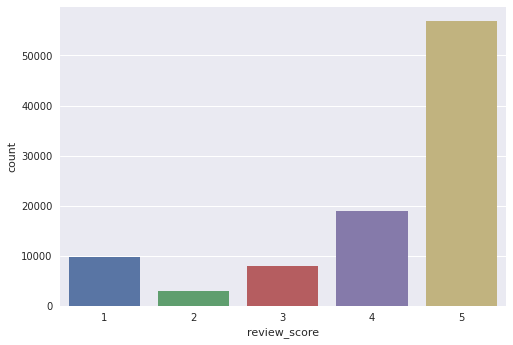

In [27]:
sns.countplot(x = 'review_score', data= orders, order=[1, 2, 3, 4, 5]);

In [53]:
review_percentages = orders.groupby(orders['review_score']).count().reset_index()
count_total = review_percentages['order_id'].sum()
review_percentages['percentage'] = review_percentages['order_id'].apply(lambda x: x / count_total)
review_percentages = review_percentages[['review_score', 'percentage']]

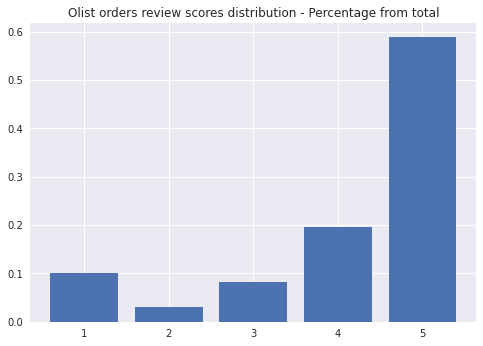

In [56]:
plt.bar(review_percentages['review_score'], review_percentages['percentage'])
plt.title('Olist orders review scores distribution - Percentage from total');

We see that out of 96 000 lines, almost 60 000  are rated 5/5. We can therefore than in the 2016-2018 period, **60% of orders entirely satisfied the customers**. 

On the contrary, **10% of orders are rated as 1**, the minimum. We will therefore have to understand why 10% of customers were unhappy and take action to limit those ratings in the future.

Moreover, we can see that are little orders that are rated 2. Are 3 and 4 positive or negative? It could be a second focus. 

In [62]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037


In [75]:
orders['order_delivered_customer_date'] = orders.merge(raw_orders[['order_id', 'order_delivered_customer_date']], on='order_id', how='inner')

In [76]:
orders.delivery_date = pd.to_datetime(orders['order_delivered_customer_date'], format='%m/%d/%y %I:%M%p')

ValueError: time data 'e481f51cbdc54678b7cc49136f2d6af7' does not match format '%m/%d/%y %I:%M%p' (match)

In [74]:
orders

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,order_delivered_customer_date
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837,2017-10-10 21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580,2018-08-07 15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333,2018-08-17 18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366,2017-12-02 00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037,2018-02-16 18:17:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96520,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08,69.481037,2017-03-17 15:08:01
96521,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245,2018-02-28 17:37:56
96522,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192,2017-09-21 11:24:17
96523,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853,2018-01-25 23:32:54


In [78]:
plt.plot(orders.order_delivered_customer_date, orders.review_score)

Error in callback <function flush_figures at 0x7f3c5bab08b0> (for post_execute):


KeyboardInterrupt: 